# 배경
주어진 데이터를 통해 개발해야 하는 게임을 정한다.

# EDA
데이터를 읽고 정리한다.

## DATA Wrangling

데이터를 불러들여, 이상치를 처리한다

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install scipy --upgrade
import scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#read Dataset
df_raw = pd.read_csv('vgames2.csv', index_col=0, na_values=['Unknown', 'Misc'])

#refine Year
df_raw.loc[df_raw.Year<=22,'Year'] += 2000
df_raw.loc[df_raw.Year<=99,'Year'] += 1900

#refine Sales data
sales_col = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for col in sales_col:
  df_raw[col] = df_raw[col].str.replace('M','')
  df_raw[col] = [(
      ele.replace('K', '') if re.match('.*K', ele) else round(float(ele) * 1000, 3)
      ) for ele in df_raw[col]]

#delete useless string in title
def del_region_sale(df_test:pd.DataFrame):
  idx = df_test['Name'].str.contains('\(.*Sale|\(.*sale')
  df_ret = df_test[idx].copy()
  for i in df_ret.index:
    name = df_ret.loc[i, 'Name']
    x = name.find(r'(')
    if name[x-1] == ' ': x -= 1
    df_ret.loc[i, 'Name'] = name[:x]
  
  return df_ret

df_raw.update(del_region_sale(df_raw))

#sort
df_raw = df_raw.sort_values(['Name', 'Platform']).reset_index(drop= True)
(df_raw.isna()).sum()

Name              0
Platform          0
Year            271
Genre          1784
Publisher       261
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
dtype: int64

##Fill NA
결측치를 채워넣는다.

In [6]:
def unite_dupl(df_test:pd.DataFrame):
  df_ret = df_test.drop_duplicates(subset= ['Name', 'Platform']).copy()
  df_raw = df_test.loc[df_test.duplicated(subset= ['Name', 'Platform'], keep= False)==True,:]
  df_add = df_raw.loc[df_raw.duplicated(subset= ['Name', 'Platform'])==True,:].copy()

  for i in df_add.index:
    name = df_add.loc[i, 'Name']
    df_sub = df_raw.query(f'Name == "{name}"')
    df_add.loc[i, sales_col] = np.sum(df_sub[sales_col].T)

  df_ret.update(df_add)
  return df_ret

def update_dupl_na(df_test, df_raw, col):
  def make_dupl(df):
    return df[df.duplicated(subset= 'Name', keep= False) == True].sort_values('Name')
    
  df_not_NA = make_dupl(df_raw).dropna(subset= [col])
  df_NA = make_dupl(df_test).loc[df_test[col].isna() == True,:].copy()

  for i in df_NA.index:
    name = df_NA.loc[i, 'Name']
    df_sub = df_not_NA.query(f'Name == "{name}"')
    if  df_sub.shape[0] > 0:
      df_NA.loc[i, col] = df_sub[col].iloc[0]

  return df_NA

def year_in_title(df):
  df_ret = df[df.Name.str.contains('\d{4}')].\
              loc[df.Year.isna() == True, :].copy()
  for i in df_ret.index:
    name = df.loc[i, 'Name']
    df_ret.loc[i, 'Year'] = int(name[-4:])

  return df_ret

def col_in_title(df_test, df_raw, col):
  df_ret = df_test[df_test[col].isna() == True].copy()
  col_unique = df_raw.dropna(subset = [col])[col].unique()

  for i in df_ret.index:
    name = df_ret.loc[i, 'Name']
    for col_u in col_unique:
      if name.find(col_u) >= 0:
        df_ret.loc[i, col] = col_u
        break
  
  return df_ret

def col_in_series(df_test, df_raw, col):
  df_not_NA = df_raw.dropna(subset= [col])
  df_NA = df_test[df_test[col].isna() == True].copy()

  for name in df_NA.Name.unique():
    name_x = name
    x = name.find(':')
    if x > 0: name_x = name[:x]
    idx = df_NA[df_NA.Name.str.contains(name_x)]
    df_sub = df_not_NA[df_not_NA.Name.str.contains(name_x)]

    if df_sub[col].unique().shape[0] == 1:
      df_NA.loc[idx, col] = df_sub[col].iloc[0]

    return df_NA


def gen_in_title_manual(df_test, df_raw, sub, gen=None):
  df_NA = df_test[df_test['Genre'].isna() == True].copy()
  
  if gen is None:
    df_not_NA = df_raw.dropna(subset= ['Genre']).loc[df_raw.Name.str.contains(sub)]
  
    if df_not_NA.shape[0] > 0:
      df_NA.loc[df_raw.Name.str.contains(sub), 'Genre'] = df_not_NA['Genre'].iloc[0]
  else:
     df_NA.loc[df_raw.Name.str.contains(sub), 'Genre'] = gen
     
  return df_NA

def clue_year(df_test:pd.DataFrame, df_raw:pd.DataFrame):
  df_not_NA = df_raw.dropna(subset= ['Year'])
  df_NA = df_test[df_test.Year.isna() == True].copy()

  for i in df_NA.index:
    name = df_NA.loc[i, 'Name']
    idx = df_NA.query(f'Name == "{name}"').index
    min = np.min(df_not_NA.Year)
    max = np.max(df_not_NA.Year)
    
    publisher = df_NA.loc[i,'Publisher']
    if publisher in df_raw.Publisher.unique():
      df_p = df_not_NA.query(f'Publisher == "{publisher}"')
      if df_p.shape[0] > 0:
        raw_p = df_p.Year

        min = np.max([min, np.min(raw_p)])
        max = np.min([max, np.min(raw_p)])

    for j in idx:
      platform = df_NA.Platform.loc[j]
      raw_p = df_not_NA.query(f'Platform == "{platform}"').Year
      
      min = np.max([min, np.min(raw_p)])
      max = np.min([max, np.min(raw_p)])

    df_NA.loc[i, 'Year'] = np.mean([min, max]).round(0)

  return df_NA

In [7]:
#make EDA dataframe
df = df_raw.loc[df_raw.Name.str.contains('\(.*wrong') == False].copy()

#find if it is separated
df.sort_values(['Name', 'Platform', 'Year', 'Genre', 'Publisher'], inplace = True)

In [8]:
#NA control
df.update(update_dupl_na(df, df_raw,'Year'))
df.update(update_dupl_na(df, df_raw,'Genre'))
df.update(update_dupl_na(df, df_raw,'Publisher'))

df.update(year_in_title(df))
df.update(col_in_title(df, df_raw, 'Genre'))
df.update(col_in_title(df, df_raw, 'Publisher'))

df.update(col_in_series(df, df_raw, 'Genre'))
df.update(col_in_series(df, df_raw, 'Publisher'))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16462 non-null  float64
 3   Genre        14868 non-null  object 
 4   Publisher    16422 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.8+ MB


In [9]:
#NA control manually
df.update(gen_in_title_manual(df, df_raw, 'Dance ?Dance'))
df.update(gen_in_title_manual(df, df_raw, 'Pokemon .*/Pokemon .*'))
df.update(gen_in_title_manual(df, df_raw, 'Amnesia'))
df.update(gen_in_title_manual(df, df_raw, 'Animal Crossing'))
df.update(gen_in_title_manual(df, df_raw, 'Momotarou Dentetsu'))
df.update(gen_in_title_manual(df, df_raw, 'Myth Makers'))
df.update(gen_in_title_manual(df, df_raw, 'The Sims'))
df.update(gen_in_title_manual(df, df_raw, 'Minecraft'))
df.update(gen_in_title_manual(df, df_raw, 'Final Fantasy'))

df.update(gen_in_title_manual(df, df_raw, 'Guitar|guitar'))
df.update(gen_in_title_manual(df, df_raw, 'Mahjong'))
df.update(gen_in_title_manual(df, df_raw, 'Chess|chess'))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16462 non-null  float64
 3   Genre        14985 non-null  object 
 4   Publisher    16422 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.8+ MB


In [10]:
#replace NAs
df.Genre.fillna('Misc', inplace= True)
df.update(clue_year(df, df_raw))
df.Publisher.fillna('Unknown', inplace= True)
df = unite_dupl(df)

df[['Platform', 'Genre', 'Publisher']] = df[['Platform', 'Genre', 'Publisher']].astype('category')
df[sales_col] = df[sales_col].astype(int)

#Data Featuring
df['Total_Sales'] = np.sum(df[sales_col].T)
df = df.convert_dtypes()
df.info()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16486 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         16486 non-null  string  
 1   Platform     16486 non-null  category
 2   Year         16486 non-null  Int64   
 3   Genre        16486 non-null  category
 4   Publisher    16486 non-null  category
 5   NA_Sales     16486 non-null  Int64   
 6   EU_Sales     16486 non-null  Int64   
 7   JP_Sales     16486 non-null  Int64   
 8   Other_Sales  16486 non-null  Int64   
 9   Total_Sales  16486 non-null  Int64   
dtypes: Int64(6), category(3), string(1)
memory usage: 1.2 MB


#시각화

처리한 데이터를 시각화한다.

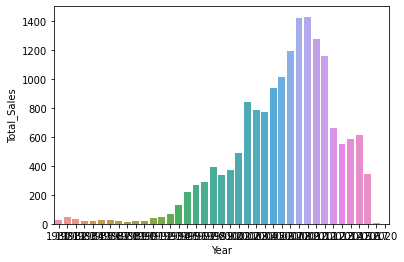

In [166]:
sns.barplot(data=df.groupby('Year')['Total_Sales'].count().reset_index(), x= 'Year',y= 'Total_Sales')
plt.show()

지역별로 어떤 장르의 게임이 인기 많은지 원그래프로 그린다.

In [11]:
def make_pie(df, min=1900, max=2022):
  df_gs = df[(df.Year >= min) & (df.Year <= max)].\
    groupby('Genre')[sales_col].sum().sort_values('NA_Sales')

  plt.figure(figsize= [16, 12])
  for i, sale in enumerate(sales_col):
    x = plt.subplot(2, 2, i+1)
    x.ax = plt.pie(data= df_gs, x= sale, labels=df_gs.index, autopct='%.1f%%')
    plt.title(f'{sale} Total: {np.sum(df[sale])}')

  plt.legend();

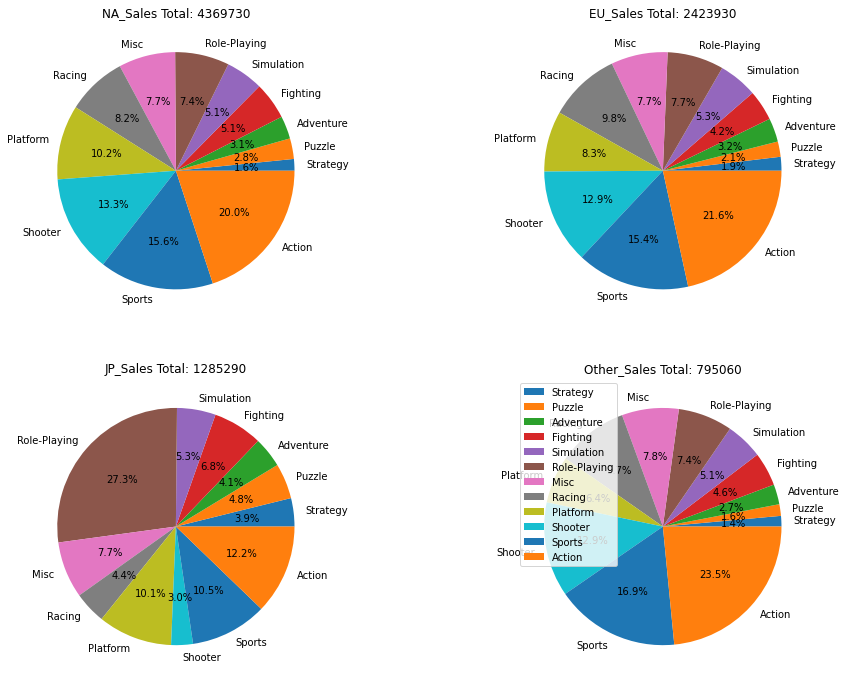

In [12]:
make_pie(df)

연도별로 어떤 장르가 트렌디한지를 본다.

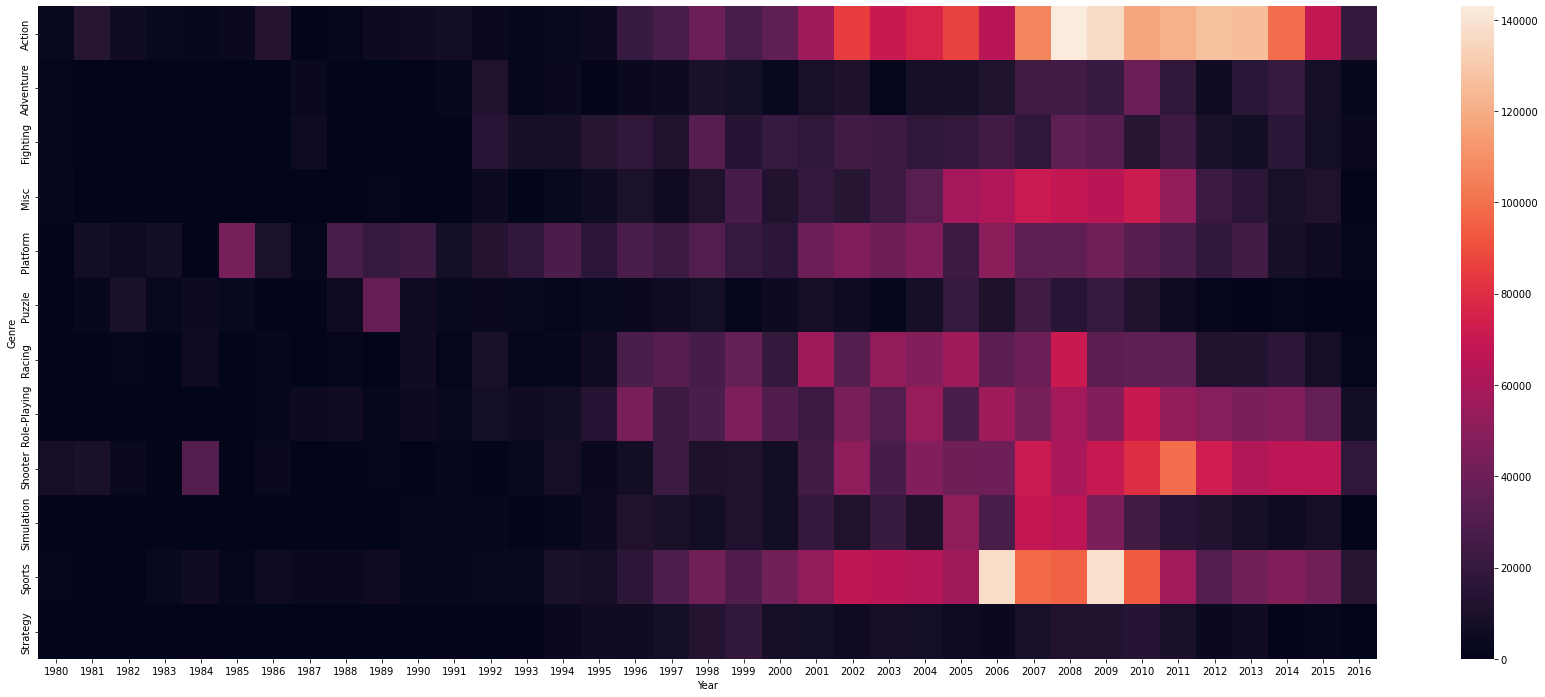

In [59]:
plt.figure(figsize=[30,12])
sns.heatmap(df[df.Year<=2016].groupby(['Year', 'Genre']).sum().astype(float).reset_index().pivot(index='Genre',columns= ['Year'], values= 'Total_Sales'))
plt.show()

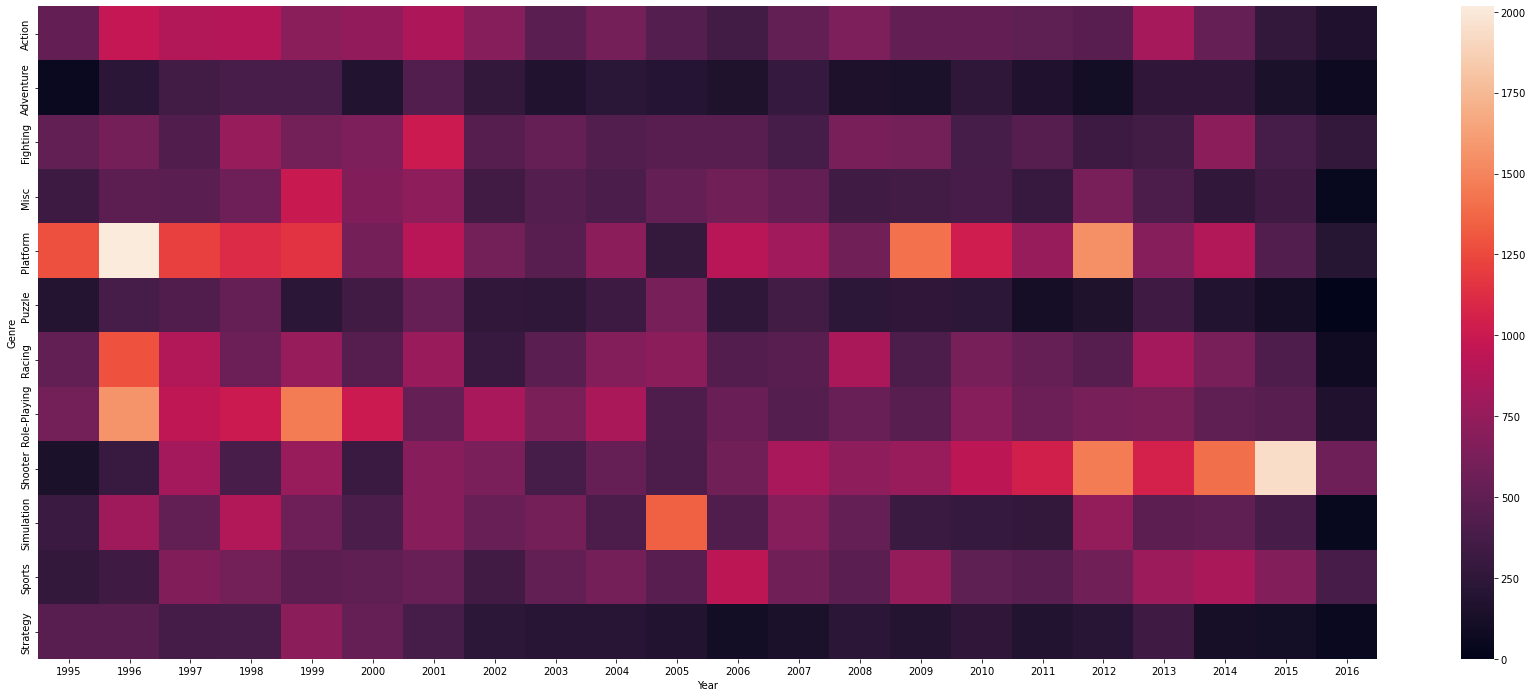

In [64]:
plt.figure(figsize=[30,12])
sns.heatmap(df[(df.Year>=1995) & (df.Year<=2016)].groupby(['Year', 'Genre']).mean().astype(float).fillna(0).reset_index().pivot(index='Genre',columns= ['Year'], values= 'Total_Sales'))
plt.show()

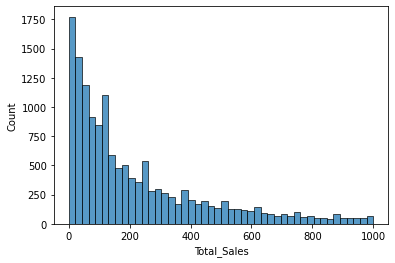

In [66]:
sns.histplot(data=df[df.Total_Sales<=1000], x= 'Total_Sales')
plt.show()

In [165]:
#df[df.Total_Sales >=1000]
plt.figure(figsize=[16,6])
plt.subplot(1, 2, 1)
df_1 = df[df.Total_Sales >=1000].groupby('Genre')['Total_Sales'].count().reset_index().sort_values('Total_Sales',ascending= False)
plt.pie(data= df_1, x= 'Total_Sales', labels='Genre', autopct='%.1f%%')
plt.title(f'Total: {np.sum(df_1.Total_Sales)}')
plt.subplot(1, 2, 2)
df_2 = df[df.Total_Sales >=1000].groupby('Publisher')['Total_Sales'].count().reset_index()
plt.pie(data= df_2.sort_values('Total_Sales').tail(10), x= 'Total_Sales', labels='Publisher', autopct='%.1f%%')
plt.title(f'Total: {np.sum(df_2.tail(10).Total_Sales)}')
plt.show()

SyntaxError: ignored

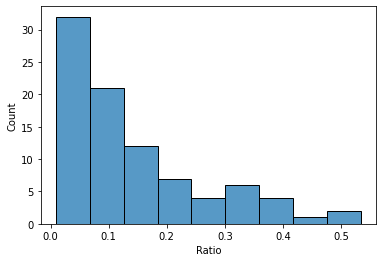

Ttest_1sampResult(statistic=1.141495030900145, pvalue=0.12838034448060687)

In [197]:
df_3 = df_2.copy()
df_3['Ratio'] = df_2['Total_Sales'] / df.groupby('Publisher')['Total_Sales'].count().reset_index()['Total_Sales']# *100
df_4 = df_1.copy()
df_4['Ratio'] = df_1['Total_Sales'] / df.groupby('Genre')['Total_Sales'].count().reset_index()['Total_Sales']
df_3 = df_3.loc[(df_3.Ratio > 0 ) & (df_3.Ratio < 0.6),:]
sns.histplot(df_3, x= 'Ratio')
plt.show()
scipy.stats.ttest_1samp(df_3['Ratio'], np.sum(df_1.Total_Sales) / df.shape[0], alternative='greater')

# 통계
주어진 데이터를 바탕으로 통계를 낸다.

In [187]:
def make_sample_mean(df, gen, per_min=2.5, per_max=97.5):
  df_sub = df.loc[df.Genre == gen, :]
  min = np.percentile(df_sub['Total_Sales'], per_min)
  max = np.percentile(df_sub['Total_Sales'], per_max)
  return np.mean(np.random.choice(
      df_sub.loc[(df.Total_Sales >= min) & (df.Total_Sales <= max)
        ,'Total_Sales']
      , size= 50))
  
def do_ttest(df):
  cols =df.columns
  dataset= [[scipy.stats.ttest_ind(df[x], df[y], alternative='greater').pvalue for y in cols] for x in cols]
  return pd.DataFrame(dataset, index=cols, columns=cols)

def make_score(df):
  return pd.DataFrame([
                       np.sum(np.where(df.loc[col,:] <= 0.05, 1, 0)) for col in df.columns
  ], index= df.columns, columns= ['Score']).sort_values('Score', ascending=False)

In [190]:
np.random.seed(42)
df_stastic=pd.DataFrame([
                         [make_sample_mean(df[(df.Year >=2007) & (df.Year <=2016)], ele) for i in range(200)]\
                         for ele in df.Genre.unique()],\
                        index= df.Genre.unique()).T

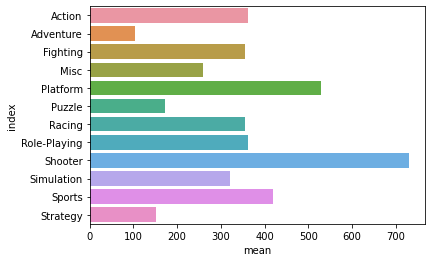

In [192]:
sns.barplot(data = df_stastic.describe().T.reset_index(), x='mean', y='index')
plt.show()

In [191]:
make_score(do_ttest(df_stastic))

,Score
Shooter,11
Platform,10
Sports,9
Role-Playing,5
Action,5
Racing,5
Fighting,5
Simulation,4
Misc,3
Puzzle,2


#결론

슈팅게임이 평균적으로 많이 벌린다. 따라서 다음분기에 개발할 게임의 장르를 슈팅게임으로 한다.